# Caricamento Librerie e Parametri

In [25]:

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

import os
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import openpyxl
import datetime
import copy
import yaml

from functions import normalize, denormalize

In [26]:
##################################################################
# parameters
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

# parameters
image_size = config['parameters']['image_size']
total_steps = config['parameters']['total_steps']
learning_rate = config['parameters']['learning_rate']
alpha = config['parameters']['alpha']
beta = config['parameters']['beta']

# path e image
folder_img_original = config['path']['folder_img_original']
folder_img_style = config['path']['folder_img_style']
folder_img_generated = config['path']['folder_img_generated']
folder_dati = config['path']['folder_dati']
name_img_original = config['path']['name_img_original']
name_img_style = config['path']['name_img_style']
name_img_generated = config['path']['name_img_generated']

# creo percorso immagini
path_img_original = os.path.join(folder_img_original, name_img_original)
path_img_style = os.path.join(folder_img_style, name_img_style)
path_img_generated = os.path.join(folder_img_generated, name_img_generated)

# creo persorso dati
data_corrente = datetime.datetime.now()
data_formattata = data_corrente.strftime("%Y_%m_%d")
dati_name = data_formattata + '_' + name_img_generated.split('.')[0] + '.xlsx'  # per salvare in formato excel
path_dati = os.path.join(folder_dati, dati_name)

# Carico e  Visualizzo le immagini

In [8]:
# creo una funzione per visualizzare le immagini caricate
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()  # modalità interattiva per visualizzare i plot
# plt.ioff() # chuido modalità interattiva

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

In [9]:
device = torch.device("cpu")

# Funzione per caricare l'immagine e convertirla in un tensore
def load_image(image_name):
    loader = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image

# Carica l'immagine
original_img = load_image(path_img_original)
style_img = load_image(path_img_style)

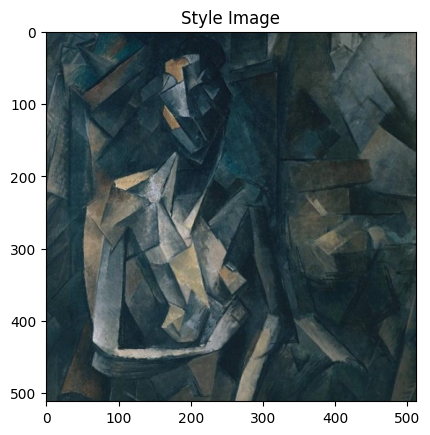

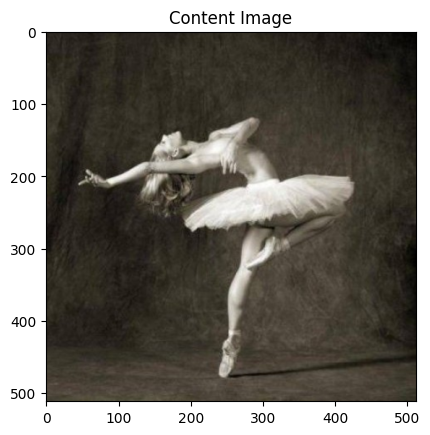

In [10]:
# visualizzo le immagini
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(original_img, title= 'Content Image')

## Transfer Color 

In [11]:
def compute_mean_std(image):
    mean = image.mean([2, 3])
    std = image.std([2, 3])
    return mean, std

def color_transfer(source, target):
    source_mean, source_std = compute_mean_std(source)
    target_mean, target_std = compute_mean_std(target)

    # Aggiungi dimensioni extra a mean e std
    source_mean = source_mean.unsqueeze(-1).unsqueeze(-1)
    source_std = source_std.unsqueeze(-1).unsqueeze(-1)
    target_mean = target_mean.unsqueeze(-1).unsqueeze(-1)
    target_std = target_std.unsqueeze(-1).unsqueeze(-1)

    result = (source - source_mean) / source_std
    result = result * target_std + target_mean
    return result

In [12]:
# devo normalizzare prima le immagini per eseguire il trasferimento di colore
style_img_normalized = normalize(style_img)
original_img_normalized = normalize(original_img)

# Applica il trasferimento del colore, ma le immagini devono essere normalizzate!!!
style_img_ct_normalized = color_transfer(style_img_normalized, original_img_normalized)  # trasferisce colore da original_img a style_img

# denormalizzo immagine
style_img_ct = denormalize(style_img_ct_normalized)


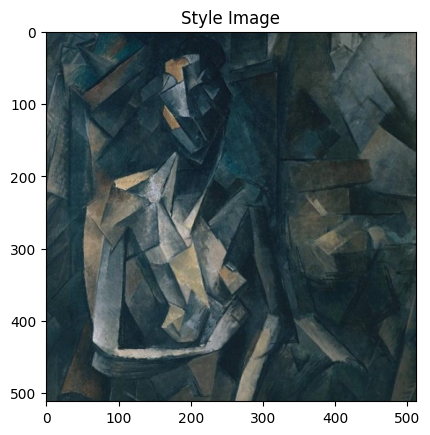

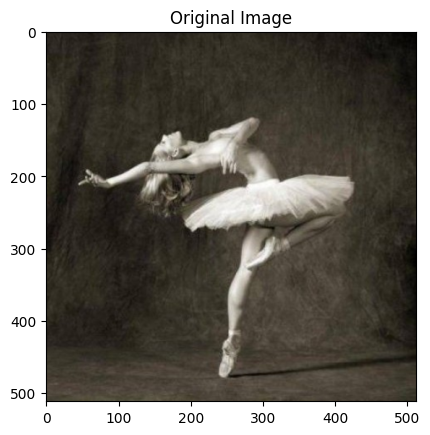

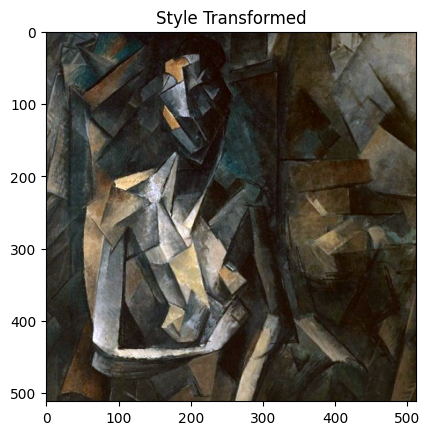

In [13]:
# Visualizzo le immagini per un confronto del trasferimento del colore
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(original_img, title='Original Image')
# imshow(style_img_transformed_normalized, title='Style Image Transformed Normalized')

plt.figure()
imshow(style_img_ct, title='Style Transformed')

# Definizione del modello VGG

In [14]:
# Carico modello pre-addestrato
vgg = models.vgg19(weights = models.VGG19_Weights.DEFAULT)

In [15]:
# Visualizzo la struttura del modello
vgg.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [16]:
# Cambio i layer MaxPool2d con layer AvgPool2d
for i, feature in enumerate(vgg.features):
    if isinstance(feature, nn.MaxPool2d):
        vgg.features[i] = nn.AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
vgg.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (

In [18]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        #Here we will use the following layers and make an array of their indices
        # 0: block1_conv1
        # 5: block2_conv1
        # 10: block3_conv1
        # 19: block4_conv1
        # 28: block5_conv1
        self.req_features= ['0','5','10','19','28'] 
        self.model=vgg.features[:29] 
    
   
    def forward(self,x):
        features=[]
        for layer_num,layer in enumerate(self.model):
            x=layer(x)
            if (str(layer_num) in self.req_features):
                features.append(x)
                
        return features

In [19]:
def calc_content_loss(gen_feat,orig_feat):
    content_loss = 0
    for gen, orig in zip(gen_feat, orig_feat):
        content_loss+=torch.mean((gen-orig)**2)#*0.5
    return content_loss
    
def calc_style_loss(gen_feat,style_feat):
    style_loss = 0
    for gen, style in zip(gen_feat, style_feat):
        batch_size,channel,height,width = gen.shape

        G=torch.mm(gen.view(channel,height*width),gen.view(channel,height*width).t())
        A=torch.mm(style.view(channel,height*width),style.view(channel,height*width).t())
        
        style_loss += torch.mean((G-A)**2)  #/(4*channel*(height*width)**2)
    return style_loss

# Addestramento del Modello

In [20]:
# Definisco funzione di addestramento
def train(model, optimizer, img_style, img_content, img_input, total_steps, alpha, beta):
    df = pd.DataFrame(columns=["Step", "Original Loss", "Style Loss", "Total Loss"])

    for step in range(total_steps):

        gen_features=model(img_input)
        orig_features=model(img_content)
        style_features=model(img_style)

        content_loss = calc_content_loss(gen_features, orig_features)
        style_loss = calc_style_loss(gen_features, style_features)
        total_loss = alpha * content_loss + beta * style_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        df.loc[step] = [step, content_loss.detach().item(), style_loss.detach().item(), total_loss.detach().item()]
        

        if step % 5 == 0 and step>0:
            print("Step: {}, Original Loss: {:4f}, Style Loss: {:4f}, Total Loss: {:4f}".format(step, content_loss.detach().item(), style_loss.detach().item(), total_loss.detach().item()))

    return df, img_input

In [21]:
#Load the model to the GPU
model=VGG().to(device).eval() 

# creo immagine di input
generated = original_img.clone()
generated_normalized = normalize(generated).requires_grad_(True)

# definisco ottimizzatore
optimizer = optim.Adam([generated_normalized], lr = learning_rate)

# addestro il modello
df, result_image_normalize = train(model, optimizer, style_img_ct_normalized, original_img_normalized, generated_normalized, total_steps, alpha, beta)

Step: 5, Original Loss: 0.050893, Style Loss: 187300576.000000, Total Loss: 1873005824.000000
Step: 10, Original Loss: 0.157268, Style Loss: 153780848.000000, Total Loss: 1537808512.000000
Step: 15, Original Loss: 0.277479, Style Loss: 124064312.000000, Total Loss: 1240643072.000000
Step: 20, Original Loss: 0.402434, Style Loss: 98473192.000000, Total Loss: 984731968.000000
Step: 25, Original Loss: 0.526875, Style Loss: 77710480.000000, Total Loss: 777104832.000000
Step: 30, Original Loss: 0.642073, Style Loss: 61832868.000000, Total Loss: 618328768.000000
Step: 35, Original Loss: 0.738865, Style Loss: 49968840.000000, Total Loss: 499688448.000000
Step: 40, Original Loss: 0.814200, Style Loss: 41091064.000000, Total Loss: 410910752.000000
Step: 45, Original Loss: 0.871019, Style Loss: 34538040.000000, Total Loss: 345380512.000000
Step: 50, Original Loss: 0.914504, Style Loss: 29830084.000000, Total Loss: 298300928.000000
Step: 55, Original Loss: 0.949012, Style Loss: 26467892.000000, T

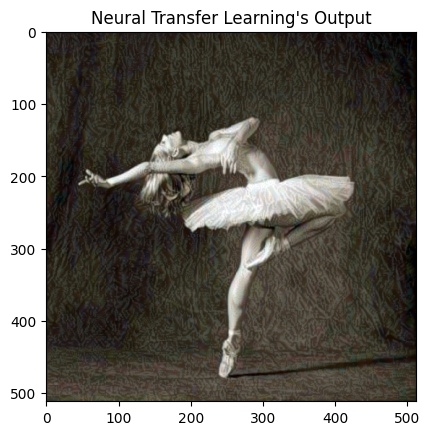

In [22]:
# visualizzo immagine finale
result_image = denormalize(result_image_normalize)

plt.figure()
imshow(result_image, title="Neural Transfer Learning's Output")

In [27]:
# salva immagine
image_numpy = result_image.cpu().detach().numpy()
image_numpy = image_numpy.squeeze()  # Rimuove la dimensione 1
image_numpy = image_numpy.astype('uint8')
image = Image.fromarray(image_numpy.transpose(1, 2, 0))  # Cambia l'ordine delle dimensioni se necessario

# Salva l'immagine come file .png
image.save(path_img_generated)

# Salvo il DataFrame con i valori delle loss functions
df.to_excel(path_dati)